In [1]:
# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda as cuda
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict

import matplotlib.pyplot as plt
import pickle as pkl

dtype = torch.FloatTensor
# Cuda active?
if cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print("GPU: {}".format(cuda.get_device_name(0)))
    cuda_available = True
else:
    cuda_available = False
    print("Cuda unavailable.")

GPU: GeForce GTX 1080 Ti


In [2]:
# %load build_autoencoder.py
import torch
import torch.nn as nn
import torch.cuda as cuda
from collections import OrderedDict

def build_autoencoder(height, width, inchannels, outchannels, filtersize, nlayers):
    samepad = int((filtersize-1)/2)

    ###########
    # Encoder #
    ###########
    encoderLayers = [nn.Conv2d(inchannels, outchannels, filtersize, padding=samepad)]
    for i in range(nlayers-1):
        encoderLayers += [nn.ReLU(), nn.Conv2d(outchannels, outchannels, filtersize, padding=samepad)]
    Encoder = nn.Sequential(*encoderLayers)

    ###########
    # Decoder #
    ########### 
    decoderLayers = [] 
    for i in range(nlayers-1):
        decoderLayers += [nn.ReLU(), nn.Conv2d(outchannels, outchannels, filtersize, padding=samepad)]
    decoderLayers += [nn.ReLU(), nn.Conv2d(outchannels, inchannels, filtersize, padding=samepad), nn.ReLU()]
    Decoder = nn.Sequential(*decoderLayers)

    ###############
    # Autoencoder #
    ###############
    Autoencoder = nn.Sequential(OrderedDict([
        ("Encoder", Encoder),
        ("Decoder", Decoder)])
    )
    return Autoencoder

In [3]:
# %load hyperspectral_dataset.py
# Load data
import torch
from torch.utils.data import Dataset
import csv, numpy as np
import os
import OpenEXR as exr, Imath
from collections import defaultdict
from PIL import Image
from skimage.transform import resize
####################
# Helper functions #
####################

def readEXRImage(filepath, channelrange):
    """Helper function for reading .exr files from the KAIST dataset.
    Returns an array with dimension ordering (C, H, W) as required by pytorch.
    """
    file = exr.InputFile(filepath)
    channels = ["w{}nm".format(wavelength) for wavelength in channelrange]
    header = file.header()
    ncols = header["displayWindow"].max.x+1
    nrows = header["displayWindow"].max.y+1
    pt = Imath.PixelType(Imath.PixelType.HALF)
    imgstrs = file.channels(channels, pt)
    full = np.zeros((len(channels), nrows, ncols), dtype=np.float16)
    for i, imgstr in enumerate(imgstrs):
        red = np.frombuffer(imgstr, dtype=np.float16)
        full[i,:,:] = np.reshape(red, (nrows, ncols))
    return full

def readPNGImage(filedir, filename, channelrange, minwavelength, increment):
    """Helper function for reading patches from the set of png files from the CAVE dataset.
    """
    indexes = [int((wavelength-minwavelength)/increment + 1) for wavelength in channelrange]
    # Get image size:
    img = Image.open(os.path.join(filedir, "{}_{:02}.png".format(filename, 1)))
    full = np.zeros((len(channelrange),) + img.size, dtype=np.float16)
    img.close()
    for i, index in enumerate(indexes):
        img = Image.open(os.path.join(filedir, "{}_{:02}.png".format(filename, index)))
        # Divide by max val of np.uint16 to normalize image
        full[i,:,:] = np.array(img, dtype=np.float32)/np.iinfo(np.uint16).max
    return full

###########
# Dataset #
###########
# For reference, the csv field names: 
# fieldnames = ["type", "dir", "name", "row", "col", "side", "scale", "flip"]

class HyperspectralDataset(Dataset):
    def __init__(self, csvfile, minwavelength, maxwavelength, nchannels, height, width):
        """Open and load the lines of the csvfile."""
        self.minwavelength = minwavelength
        self.maxwavelength = maxwavelength
        self.channelrange = range(self.minwavelength, self.maxwavelength+1, 10)
        
        
        # Store dictionaries mapping the image name to
        # - a list of entries that stem from that image
        # - the datatype (exr or png) of the image
        # - the filepath to that image
        self.update_entries(csvfile)

    def update_entries(self, csvfile):
        """Refresh the dataset without reloading the images, but adding a different set of csv files."""
        self.dataEntries = []
        self.namesToImages = {}
        with open(csvfile, "r") as f:
            reader = csv.DictReader(f)
            for entry in reader:
                self.dataEntries.append(entry)
                # Add the full image to the dict if not already included.
                if entry["name"] not in self.namesToImages:
                    print("loading {}".format(entry["name"]))
                    # Need to read the image into the dictionary
                    if entry["type"] == "exr":
                        filepath = os.path.join(entry["dir"], entry["name"])
                        self.namesToImages[entry["name"]] = readEXRImage(filepath, self.channelrange)
                    elif entry["type"] == "png":
                        self.namesToImages[entry["name"]] = readPNGImage(entry["dir"], entry["name"],
                                                                           self.channelrange,
                                                                           self.minwavelength,
                                                                           self.maxwavelength)
                    else:
                        raise ValueError("Invalid entry at row {} - Cannot load data of type '{}'.".format(idx, dtype))
                    print("\tSize: {} bytes.".format(self.namesToImages[entry["name"]].nbytes))
                    
    def __len__(self):
        return len(self.dataEntries)
    
    def __getitem__(self, idx):
        entry = self.dataEntries[idx]
        image = self.namesToImages[entry["name"]]
        side = int(entry["side"])
        scale = float(entry["scale"])
        i = int(entry["row"])
        j = int(entry["col"])
        shape = (int(side/scale),
                 int(side/scale)
                )
        patch = image[:, i:i+shape[0], j:j+shape[0]]
        # Resizing
        patch = resize(patch, (patch.shape[0], side, side), mode="constant")
        # Flip if necessary:
        if entry["flip"]:
            patch = np.flip(patch, axis=2) # Horizontal flip

        # Convert to Torch tensor and return
        out = torch.Tensor(patch.copy()).type(dtype).cpu()
        return out



In [316]:
# Build model and loss
# Hyperparameters
height = 96
width = 96
inchannels = 29
outchannels = 64
filtersize = 3
nlayers = 11
samepad = int((filtersize-1)/2)

Autoencoder = build_autoencoder(height, width, inchannels, outchannels, filtersize, nlayers)
# Load checkpoint
checkpointfile = "checkpoints/checkpoint_epoch_59.pth.tar"
if cuda.is_available():
    checkpoint = torch.load(checkpointfile)
else:
    # Load GPU model on CPU
    checkpoint = torch.load(checkpointfile,
                            map_location=lambda storage,
                            loc: storage)
Autoencoder.load_state_dict(checkpoint['state_dict'])

### Simulate image formation

In [6]:
#%%writefile simulate_cassi.py
# Simulate CASSI (Spatial-spectral or SS-CASSI, to be specific)
import numpy as np
import torch
from scipy.ndimage.interpolation import shift

# Generate random binary mask
mask = np.random.choice(2, size=(height, width+inchannels), p=(0.5, 0.5))
plt.imshow(mask)

# Shear mask by different amounts for each channel
middlechannel = int((inchannels - 1)/2)
shifts = [ shift for shift in range(-middlechannel, middlechannel+1) ]

# Apply mask to each channel (element-wise multiplication)
maskblock = np.zeros((inchannels, height, width+inchannels), dtype=np.float32)
for i, shift_val in enumerate(shifts):
#     print(shift_val)
    # Shift mask along horizontal axis only
    # in (C, H, W) order (for pytorch later)
    maskblock[i,:,:] = shift(mask, (0, shift_val), mode='constant')
middle = (width+inchannels+1)/2
# print(middle)
# print(range(int(middle-width/2),int(middle+width/2)))
maskblock = maskblock[:, :, int(middle-width/2):int(middle+width/2)]
# print(maskblocksquare.shape)
# plt.imshow(maskblocksquare[25,:,:])
maskblock = torch.Tensor(maskblock).type(dtype)
maskblock = Variable(maskblock, requires_grad=False)
maskblock = maskblock.unsqueeze(0) # Make 4d tensor
# print(maskblock.shape)
    
# Define image formation model
def image_formation(input_, maskblock):
    """Given an (1, inchannels, height, width) data block input_ and
    a torch tensor mask, compute the image that the camera sensor should see."""
    # Multiply elementwise by mask
#     print(type(maskblock))
#     print(type(input_))
#     print(maskblock.shape)
#     print(input_.shape)
    x = maskblock*input_
#     print(x.shape)
    # Sum along wavelength dimension to get a 2D image (1, height, width)
    return torch.sum(x, dim=1).unsqueeze(0) #Unsqueeze to make (1, 1, height, width)

Writing simulate_cassi.py


In [272]:
# Load val image(s)
val_data_csv = "data/kaist_set/kaist_select.csv"
val_data = HyperspectralDataset(val_data_csv, 420, 700, inchannels, height, width)

loading scene22_reflectance.exr
	Size: 529464832 bytes.
loading scene17_reflectance.exr
	Size: 529464832 bytes.
loading scene26_reflectance.exr
	Size: 529464832 bytes.


In [5]:
from colorsys import rgb_to_hsv, hsv_to_rgb
# Visualize hyperspectral images
def plot_all_channels(data, channels_to_wavelengths):
    """Plot the channels in the data, color coded by wavelength.
    channels_to_wavelengths[i] gives the wavelength in nm of the ith channel."""
    plt.figure(figsize=(15, 20))
    inchannels = data.shape[1]
    for channel in range(inchannels):
        wavelength = channels_to_wavelengths[channel]
        r, g, b = spectral_color(wavelength)
        
        low = hsv_to_rgb(h, s, 0)
        high = hsv_to_rgb(h, s, 1)
        cdict = {"red": ((0.0, 0.0, 0.0),
                         (1.0, r, r)),
                 "green": ((0.0, 0.0, 0.0),
                           (1.0, g, g)),
                 "blue":  ((0.0, 0.0, 0.0),
                           (1.0, b, b))
        }
        lambd = LinearSegmentedColormap('lambd', cdict)

        ax = plt.subplot(inchannels//4+1,4, channel+1)

        ax.imshow(data[0,channel,:,:], cmap=lambd)
        plt.tight_layout()

# Adapted from
# https://stackoverflow.com/questions/3407942/rgb-values-of-visible-spectrum/22681410#22681410
def spectral_color(l): # RGB <0,1> <- lambda l <400,700> [nm]
    # R
    if l>=400.0 and l<410.0:
        t = (l-400.0)/(410.0-400.0)
        r = (0.33*t)-(0.20*t*t)
    elif l>=410.0 and l<475.0:
        t = (l-410.0)/(475.0-410.0)
        r = 0.14 - (0.13*t*t)
    elif l>=545.0 and l<595.0:
        t = (l-545.0)/(595.0-545.0)
        r = (1.98*t)-(     t*t)
    elif l>=595.0 and l<650.0:
        t = (l-595.0)/(650.0-595.0)
        r = 0.98+(0.06*t)-(0.40*t*t)
    elif l>=650.0 and l<700.0:
        t = (l-650.0)/(700.0-650.0)
        r = 0.65-(0.84*t)+(0.20*t*t)
    # G
    if l>=415.0 and l<475.0:
        t = (l-415.0)/(475.0-415.0)
        g = (0.80*t*t)
    elif l>=475.0 and l<590.0:
        t = (l-475.0)/(590.0-475.0)
        g = 0.8 +(0.76*t)-(0.80*t*t)
    elif l>=585.0 and l<639.0:
        t = (l-585.0)/(639.0-585.0)
        g = 0.84-(0.84*t)
    # B
    if l>=400.0 and l<475.0:
        t = (l-400.0)/(475.0-400.0)
        b = (2.20*t)-(1.50*t*t)
    elif l>=475.0 and l<560.0:
        t = (l-475.0)/(560.0-475.0)
        b = 0.7 - t+(0.30*t*t)
    return r, g, b


OrderedDict([('type', 'exr'), ('dir', 'data/KAIST'), ('name', 'scene17_reflectance.exr'), ('row', '1248'), ('col', '1510'), ('side', '96'), ('scale', '1'), ('flip', 'False')])


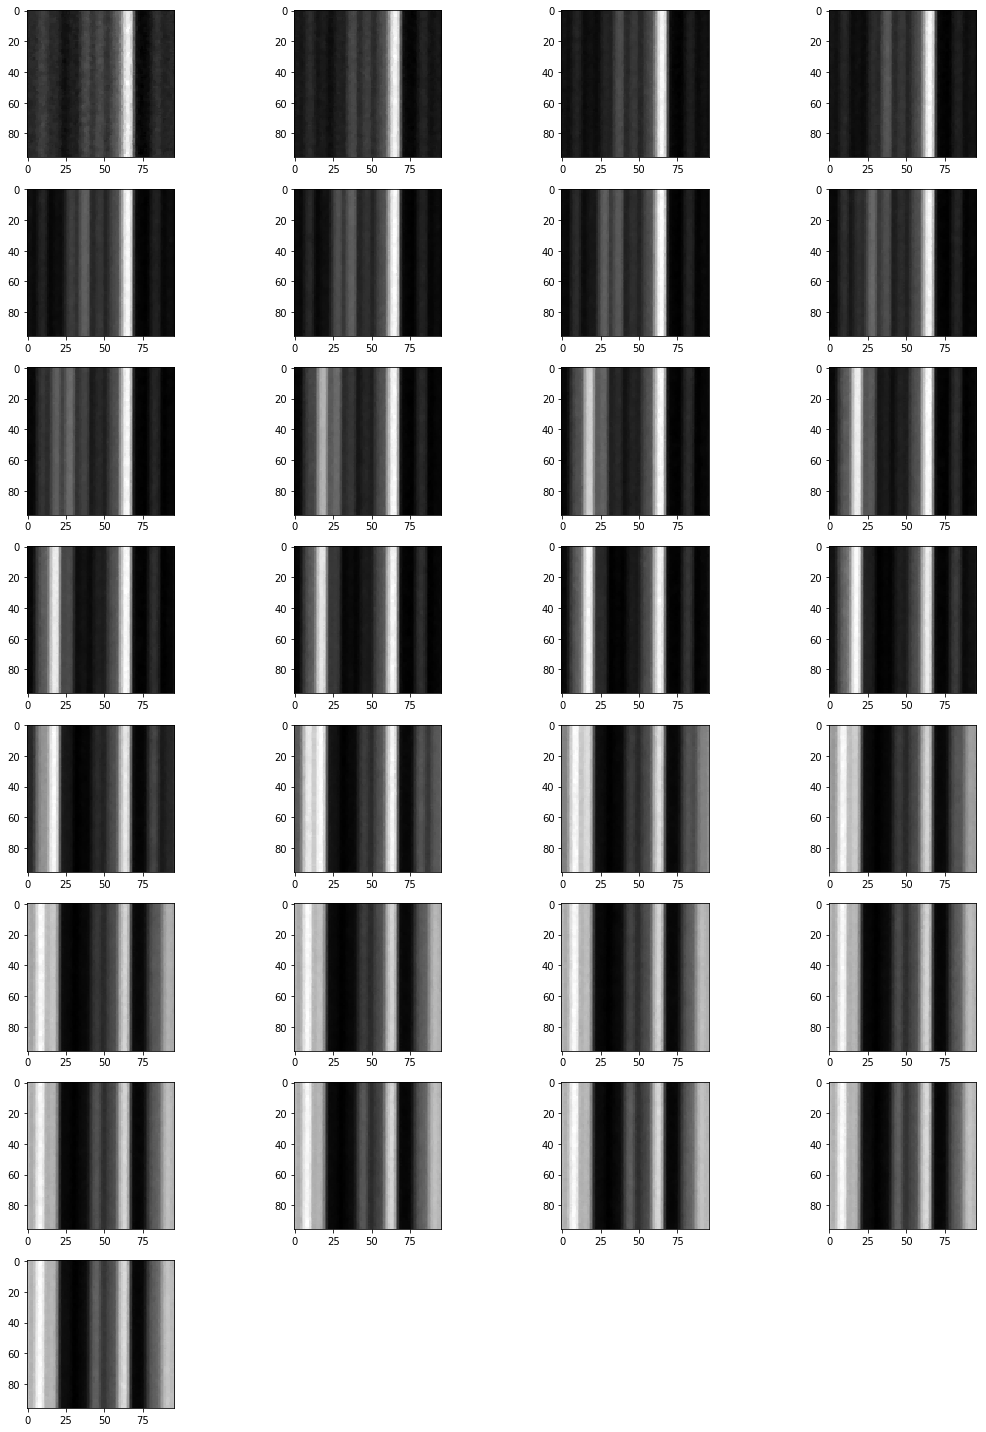

In [329]:
# Load image to reconstruct
n=7
print(val_data.dataEntries[n])
true_img = Variable(torch.Tensor(val_data[n]).type(dtype), requires_grad=False)
true_img = true_img.unsqueeze(0) # make 4d Variable
target = image_formation(true_img, maskblock)
# print(target.shape)
# plt.imshow(target.data[0,0,:,:]")
# type(target)
# print(target.is_cuda)
# print(type(target))
plot_all_channels(true_img.data)

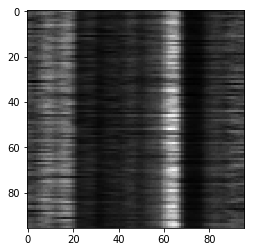

In [330]:
# Show target image:
plt.imshow(target.data[0,0,:,:], cmap='gray')

### ADMM Reconstruction
#### Optimization problem and ADMM parameters

For reference, the optimization problem is given by
$$
\text{minimize} \quad \|i - \Phi D(\alpha) \|_2^2 + \tau_1\|\alpha - E(D(\alpha))\| + \tau_2\|\nabla_{xy} D(\alpha)\|
$$

In [331]:
import torch.nn.functional as F

# ADMM Hyperparameters (as set in paper)
tau1 = 0.1
tau2 = 1e-3
rho = 1e-1
num_ADMM_steps = 20
eps = 1e-4 # Stopping criterion

# Adam hyperparameters
num_adam_iters = 200
lr = 5e-2

# TV Gradient operator
def Delxy(img):
    """Computes the first difference in the x and y directions"""
    _, nchannels, height, width = img.shape
#     print(nchannels)
#     print(type(img))
    Dx = torch.cat((img[:,:,:,1:], 
                    Variable(torch.zeros(1, nchannels, height, 1).type(dtype), requires_grad=False)), dim=3) \
         - img
    Dy = torch.cat((img[:,:,1:,:], 
                    Variable(torch.zeros(1, nchannels, 1, width).type(dtype), requires_grad=False)), dim=2) \
         - img
    Dxy = torch.cat((Dx, Dy), dim=1)
#     print(Dxy.is_cuda)
    return Dxy

# MSE Loss
# Need to be able to compute gradients w.r.t. input and target
def mse_loss(input_, target):
    return torch.sum((input_ - target)**2) #/ input_.data.nelement()

# Define proximal operators for each term
def proximal_alpha(target, alpha, z, u, Encoder, Decoder, image_formation, maskblock, tau1, rho, num_adam_iters, lr):
    """ Proximal operator for latent variable alpha.
    target - torch.Tensor - The image whose spectrum we are trying to reconstruct.
    alpha - torch.Variable - The latent variable representing the latent spectrum.
    Encoder, Decoder - torch.Sequential - The layers representing the autoencoder. 
    image_formation - function - defines the mapping from hyperspectral image to output image
        via SS-CASSI
    tau1 - float - Regularization hyperparameter.
    num_adam_steps - int - Number of steps to run Adam
    lr - float - Adam learning rate.
    """
    # Gradient descent
#     if cuda.is_available():
#         data_fidelity_loss.cuda()
#         autoencoder_prior_loss.cuda()
    optimizer = optim.Adam([alpha], lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)

#     print(alpha.is_cuda)
    for it in range(num_adam_iters):
        scheduler.optimizer.zero_grad()
        data_fidelity = mse_loss(target, image_formation(Decoder(alpha), maskblock))
#         autoencoder_prior = mse_loss(alpha, Encoder(Decoder(alpha)))
#         print(Delxy(Decoder(alpha)).shape)
#         print(z.shape)
        augmented_lagrangian = mse_loss(Delxy(Decoder(alpha)) + u, z)
        overall_loss = data_fidelity + rho/2*augmented_lagrangian#  + tau1*autoencoder_prior
        overall_loss.backward(retain_graph=True)
        if not (it % 50):
#             print("\tadam_iteration: {}\tap_loss: {}".format(it, autoencoder_prior.data[0]))
            print("\tadam_iteration: {}\toverall_loss: {}".format(it, overall_loss.data[0]))
            print("\t\tdfl: {}\tall: {}".format(data_fidelity.data[0], augmented_lagrangian.data[0]))
#             print("\t\tdfl: {}\tapl: {}\tall: {}".format(data_fidelity.data[0], autoencoder_prior.data[0],
#                                                          augmented_lagrangian.data[0]))
#             print(torch.norm(alpha.grad).data[0])
        scheduler.optimizer.step()
        scheduler.step()

#         print(alpha.grad)
    return alpha

def proximal_z(v, tau2, rho):
    """Element-wise soft thresholding operator.
    Used for Anisotropic TV prior."""
    out = F.relu(v - tau2/rho) - F.relu(-v - tau2/rho)
    return out




In [332]:
# Extract encoder and decoder:
Encoder = Autoencoder[0]
Decoder = Autoencoder[1]

# Initialize ADMM
# This is the only thing that should be optimized!
alpha = Variable(torch.randn(1, outchannels, height, width).type(dtype), requires_grad=True)
z = Variable(torch.randn(1, 2*inchannels, height, width).type(dtype), requires_grad=False)
u = Variable(torch.randn(1, 2*inchannels, height, width).type(dtype), requires_grad=False)
if cuda.is_available():
    Encoder.cuda()
    Decoder.cuda()

# Run ADMM
for admm_i in range(num_ADMM_steps):
    print("iteration: {}".format(admm_i))


    # Update alpha
    newalpha = proximal_alpha(target, alpha, z, u, 
                           Encoder, Decoder, image_formation, 
                           maskblock, tau1, rho, num_adam_iters, lr)
    Dxy_alpha = Delxy(Decoder(newalpha))
    # Update z
    newz = proximal_z(Dxy_alpha + u, tau2, rho)
    # Update u
    newu = u + Dxy_alpha - newz
    # Calculate loss
    loss = mse_loss(target, image_formation(Decoder(newalpha), maskblock)) + \
               tau2 * torch.sum(torch.abs(Delxy(Decoder(newalpha))))
#            tau1 * mse_loss(alpha, Encoder(Decoder(newalpha))) + \ 
#     print("loss: {}".format(loss.data[0]))
    # Stop if parameters aren't changing:
    if (torch.sum(torch.abs(alpha - newalpha)) +
       torch.sum(torch.abs(z - newz)) +
       torch.sum(torch.abs(u - newu))).data[0] < eps:
        break
    else:
        alpha = newalpha
        z = newz
        u = newu


iteration: 0
	adam_iteration: 0	overall_loss: 212204.3125
		dfl: 158616.71875	all: 1071752.0
	adam_iteration: 50	overall_loss: 54016.26171875
		dfl: 504.304931640625	all: 1070239.125
	adam_iteration: 100	overall_loss: 53716.26953125
		dfl: 206.49818420410156	all: 1070195.375
	adam_iteration: 150	overall_loss: 53706.74609375
		dfl: 197.0773468017578	all: 1070193.375
iteration: 1
	adam_iteration: 0	overall_loss: 26057.91015625
		dfl: 190.06423950195312	all: 517356.90625
	adam_iteration: 50	overall_loss: 25990.9765625
		dfl: 123.52043151855469	all: 517349.125
	adam_iteration: 100	overall_loss: 25979.203125
		dfl: 111.71232604980469	all: 517349.8125
	adam_iteration: 150	overall_loss: 25978.14453125
		dfl: 110.65074157714844	all: 517349.875
iteration: 2
	adam_iteration: 0	overall_loss: 114.02397155761719
		dfl: 109.67527770996094	all: 86.97380065917969
	adam_iteration: 50	overall_loss: 109.23818969726562
		dfl: 104.8748779296875	all: 87.26628112792969
	adam_iteration: 100	overall_loss: 104.

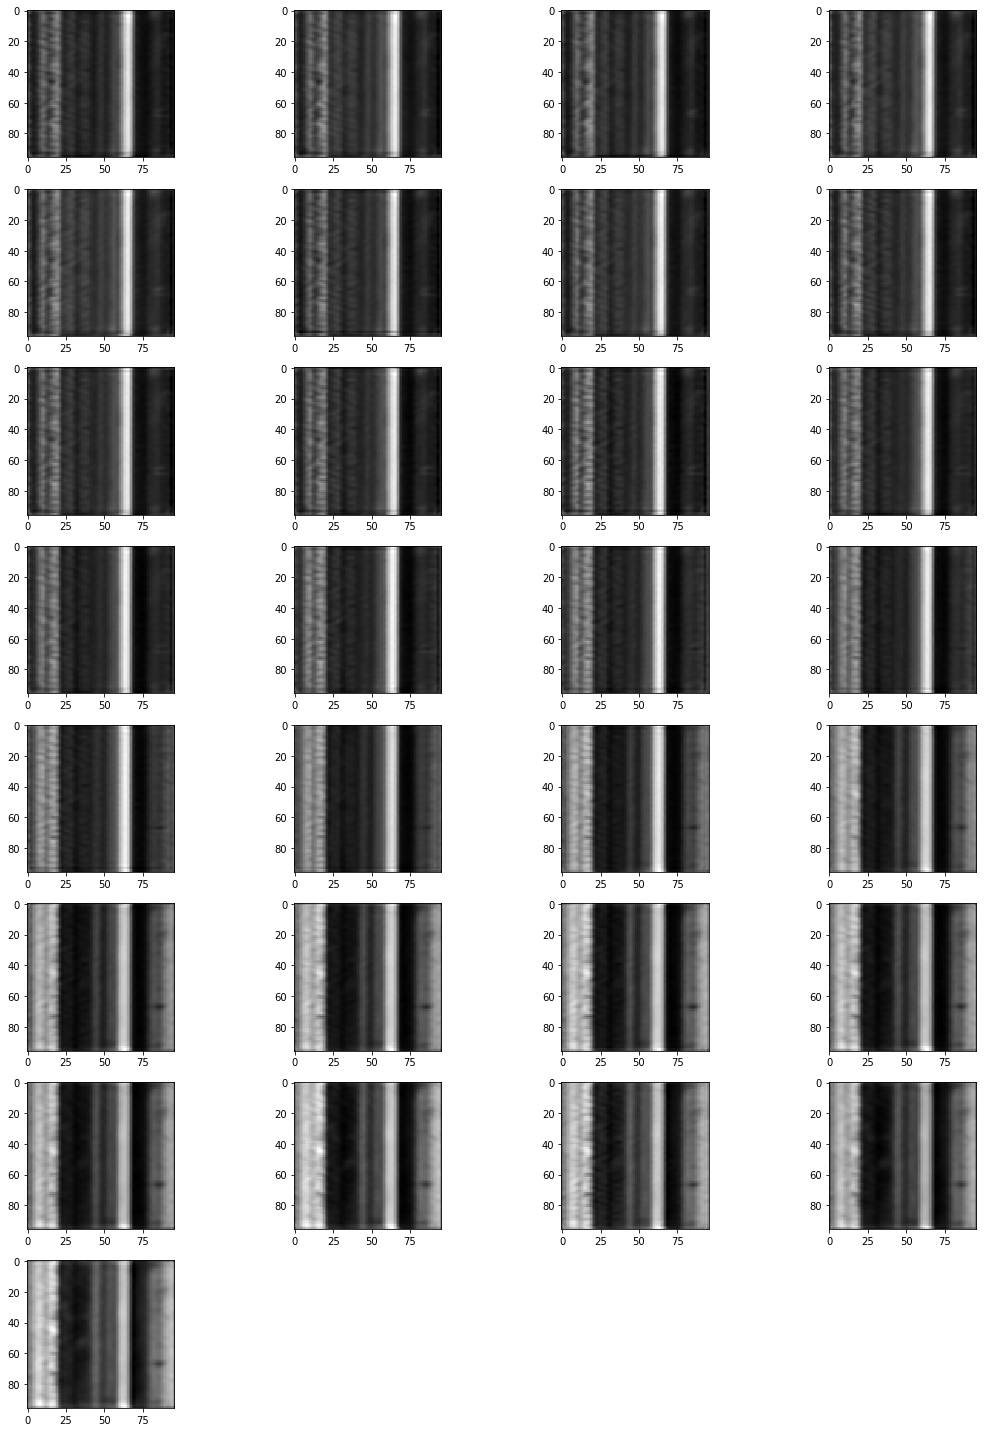

In [333]:
# Plot Decoded image
recon = Decoder(alpha).data
plot_all_channels(recon)

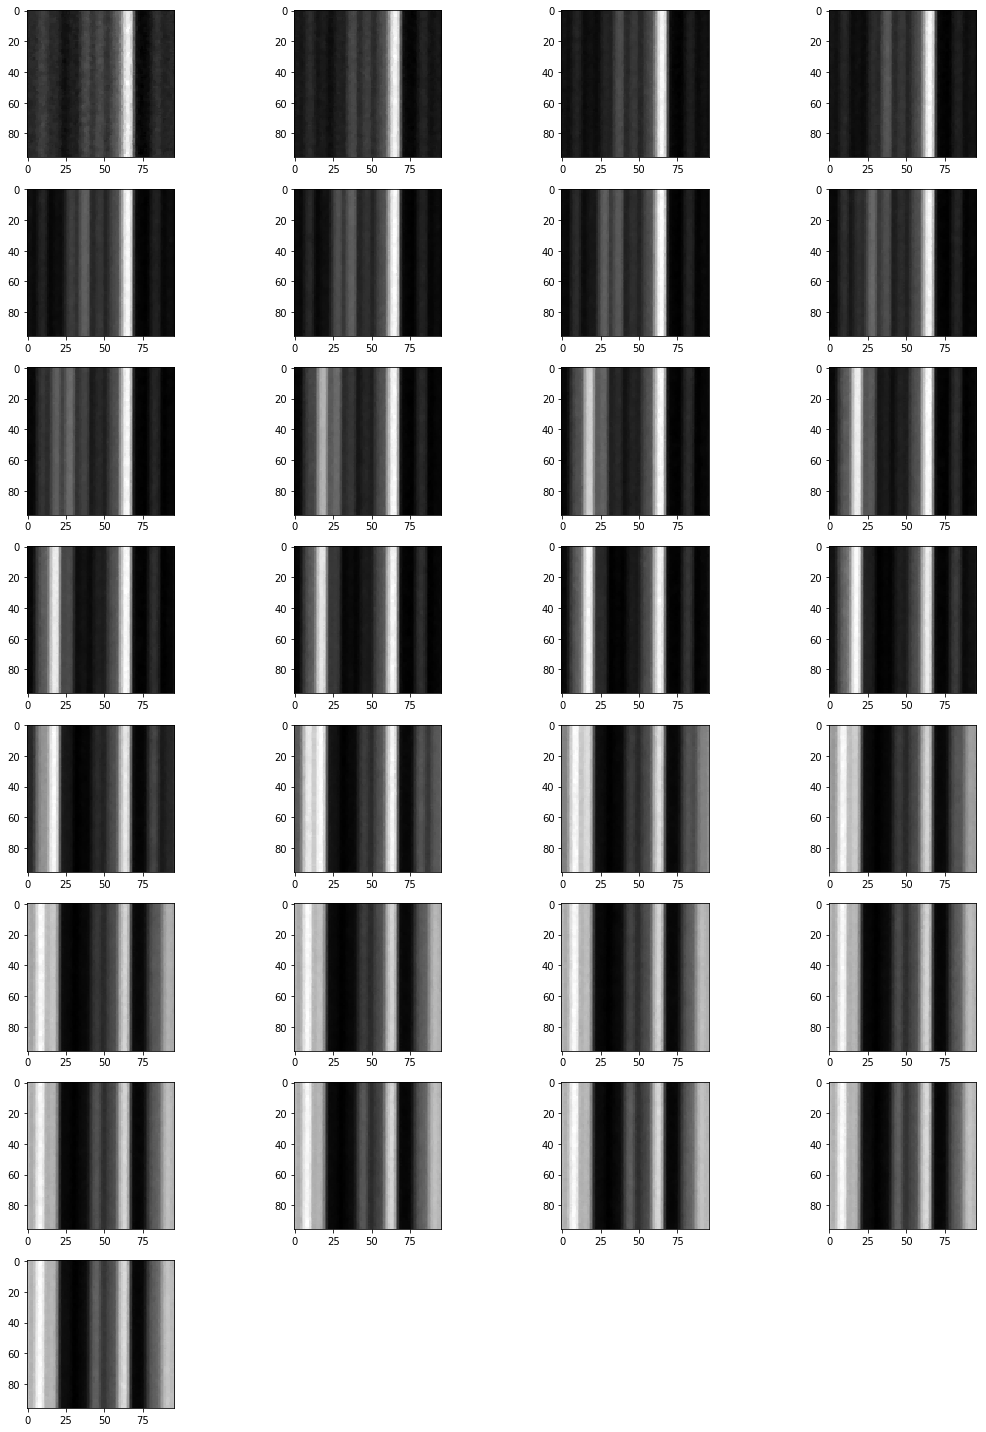

In [334]:
# print(true_img[0,0,:,:].data)
plot_all_channels(true_img.data)

In [335]:
# Compute PSNR
from skimage.measure import compare_psnr
compare_psnr(true_img.data.cpu().numpy(), recon.cpu().numpy())

26.57672776113096

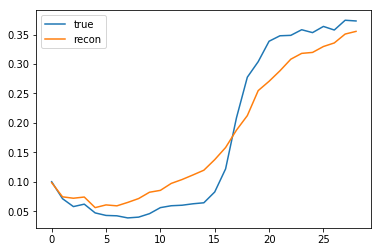

In [336]:
plt.plot(true_img.data[0,:,4,4].cpu().numpy(), label="true")
plt.plot(recon[0,:,4,4].cpu().numpy(), label="recon")
plt.legend()

In [ ]:
dir()

In [ ]:
a = torch.Tensor([-3, -1, 1, 3])
b = (-0.5 < a)
c = (a < 0.5)

In [ ]:
import numpy as np
np.logical_and(b, c)

In [ ]:
proximal_z(a, 2, 1)